# Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of functional images with FSL's MCFLIRT
2. Coregistration of functional images to anatomical images (according to FSL's FEAT pipeline)
3. Smoothing of coregistrated functional images with FWHM set to 4mm and 8mm
4. Artifact Detection in functional images (to detect outlier volumes)

## Imports

First, let's import all modules we later will be needing.

In [6]:
%pylab inline
from os.path import join as opj
import json
from nipype.interfaces.fsl import MCFLIRT, FLIRT
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

Populating the interactive namespace from numpy and matplotlib
171210-19:48:01,254 interface WARNING:
	 Could not get linked libraries for "which".


# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [23]:
data_dir = '/home/neuro/nipype_tutorial/data/PSYC405/'

experiment_dir = '/home/neuro/nipype_tutorial/output/'
output_dir = '/home/neuro/nipype_tutorial/output/datasink'
working_dir = '/home/neuro/nipype_tutorial/output/workingdir'

# list of subject identifiers
subject_list = ['sub-1']


# list of session identifiers
task = 'handsqueeze'


# list of session identifiers
session_list = ['run-3']
#                 'run-02',
#                 'run-03', 'run-04', 'run-05',
#                 'run-06', 'run-07', 'run-08', 'run-09', 'run-10',
#                 'run-11', 'run-12']

# TR of functional images
# with open(data_dir+'task-objectviewing_bold.json', 'rt') as fp:
#     task_info = json.load(fp)
# TR = task_info['RepetitionTime']
# print('TR = %0.2f'%TR)
TR = 2.0

# Smoothing withds used during preprocessing
fwhm = [4]


TR = 2.50


## Specify Nodes for the main workflow

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [24]:
# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")


# FLIRT - coregister functional images to anatomical images
coreg_step1 = Node(FLIRT(output_type='NIFTI'), name="coreg_step1")
coreg_step2 = Node(FLIRT(output_type='NIFTI',
                         apply_xfm=True), name="coreg_step2")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [25]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'session_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('session_id', session_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('{subject_id}', 'anat', '{subject_id}_T1w.nii')
func_file = opj('{subject_id}', 'func',
                '{subject_id}_%s_{session_id}_bold.nii'%task)

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=data_dir),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id', ''),
                 ('_session_id_', ''),
                 ('_task', ''),
                 ('_mcf.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('%s_%s/' % (sess, sub), '%s/%s' % (sub, sess))
               for sess in session_list
               for sub in subject_list]
subjFolders += [('%s_%s' % (sub, sess), '')
                for sess in session_list
                for sub in subject_list]
subjFolders += [('%s%s_' % (sess, sub), '')
                for sess in session_list
                for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [26]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('session_id', 'session_id')]),
                 (selectfiles, mcflirt, [('func', 'in_file')]),

                 (mcflirt, coreg_step1, [('mean_img', 'in_file')]),
                 (selectfiles, coreg_step1, [('anat', 'reference')]),

                 (mcflirt, coreg_step2, [('out_file', 'in_file')]),
                 (selectfiles, coreg_step2, [('anat', 'reference')]),
                 (coreg_step1, coreg_step2, [('out_matrix_file',
                                              'in_matrix_file')]),

                 (coreg_step2, smooth, [('out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (selectfiles, datasink, [('anat', 'preproc.@resample')]),
                 (coreg_step1, datasink, [('out_file', 'preproc.@coregmean')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

171210-19:53:43,898 interface WARNING:
	 Could not get linked libraries for "dot".
171210-19:53:44,436 workflow INFO:
	 Generated workflow graph: /home/arash/Downloads/output/workingdir/preproc/graph.dot.png (graph2use=colored, simple_form=True).


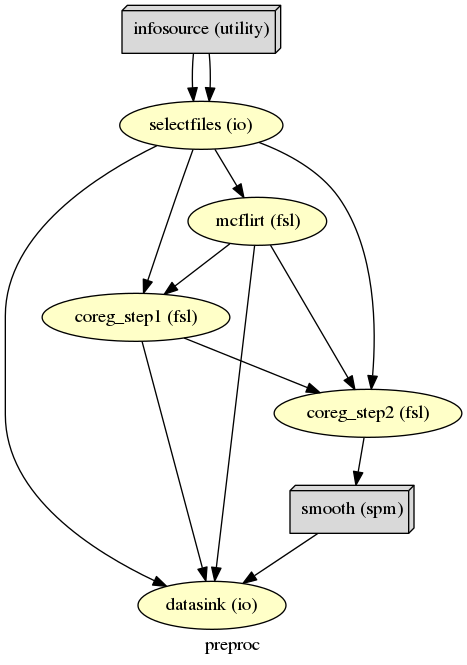

In [27]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

171210-19:53:44,490 interface WARNING:
	 Could not get linked libraries for "dot".
171210-19:53:44,792 interface WARNING:
	 Could not get linked libraries for "dot".
171210-19:53:44,952 workflow INFO:
	 Generated workflow graph: /home/arash/Downloads/output/workingdir/preproc/graph.dot.png (graph2use=flat, simple_form=True).


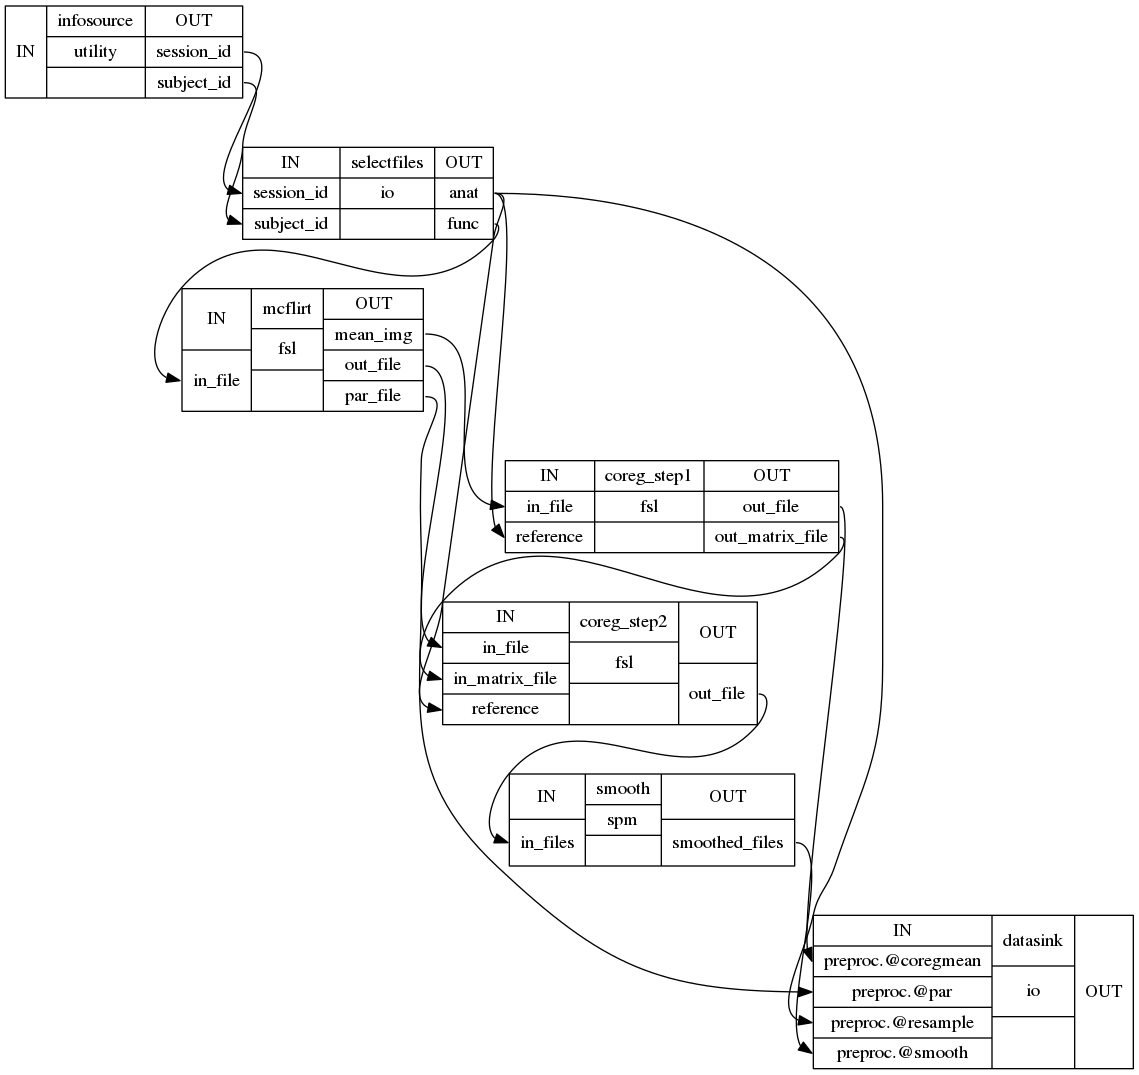

In [28]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. **Note** that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [29]:
preproc.run()

# !nipypecli crash /home/neuro/nipype_tutorial/crash-20171202-160850-neuro-resample.b11-28ee9940-3aa2-4176-bed8-e68cdda9bcd1.pklz

171210-19:53:46,197 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
171210-19:53:46,346 workflow INFO:
	 Running serially.
171210-19:53:46,350 workflow INFO:
	 Executing node preproc.selectfiles in dir: /home/arash/Downloads/output/workingdir/preproc/_session_id_run-01_subject_id_sub-1/selectfiles
171210-19:53:46,361 workflow INFO:
	 Running node "selectfiles" ("nipype.interfaces.io.SelectFiles").
171210-19:53:46,394 workflow INFO:
	 Executing node preproc.mcflirt in dir: /home/arash/Downloads/output/workingdir/preproc/_session_id_run-01_subject_id_sub-1/mcflirt
171210-19:53:46,411 workflow INFO:
	 Running node "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/arash/Downloads/data/ds000105/sub-1/func/sub-1_task-objectviewing_run-01_bold.nii.gz -meanvol -out /home/arash/Downloads/output/workingdir/preproc/_session_id_run-01_subject_id_sub-1/mcflirt/sub-1_task-objectviewing_run-01_bo

RuntimeError: Workflow did not execute cleanly. Check log for details

# Example 2: 1st-level Analysis using GLM

In this part we will take the preprocessed output from the first part and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

**So, let's begin!**

# Imports

First, we need to import all modules we later want to use.

In [34]:
%pylab inline
from os.path import join as opj
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node

Populating the interactive namespace from numpy and matplotlib


# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [77]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

# Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate.

In [41]:
# Condition names
condition_names = ['scissors', 'face', 'cat', 'shoe', 'house',
                   'scrambledpix', 'bottle', 'chair']
# condition_names = ['face', 'scrambledpix']


# Contrasts
contL1= 'face T-contrast'
contL2= 'house T-contrast'
contL3= 'face>house T-contrast'
contL4= 'house<face T-contrast'
contL5= 'face F-contrast'
contL6= 'house F-contrast'
contL7= 'face vs house F-contrast'

cont01 = [contL1,      'T', condition_names, [0, 1, 0, 0, 0, 0, 0, 0]]
cont02 = [contL2,    'T', condition_names, [0, 0, 0, 0, 1, 0, 0, 0]]
cont03 = [contL3,  'T', condition_names, [0, 1, 0, 0, -1, 0, 0, 0]]
cont04 = [contL4,  'T', condition_names, [0, -1, 0, 0, 1, 0, 0, 0]]

cont05 = [contL5,     'F', [cont01]]
cont06 = [contL6,     'F', [cont02]]
cont07 = [contL7,    'F', [cont03, cont04]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07]

# Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

In [42]:
!cat {data_dir}sub-1/func/sub-1_task-objectviewing_run-01_events.tsv

onset	duration	trial_type
12.000	0.500	scissors
14.000	0.500	scissors
16.000	0.500	scissors
18.000	0.500	scissors
20.000	0.500	scissors
22.000	0.500	scissors
24.000	0.500	scissors
26.000	0.500	scissors
28.000	0.500	scissors
30.000	0.500	scissors
32.000	0.500	scissors
34.000	0.500	scissors
48.000	0.500	face
50.000	0.500	face
52.000	0.500	face
54.000	0.500	face
56.000	0.500	face
58.000	0.500	face
60.000	0.500	face
62.000	0.500	face
64.000	0.500	face
66.000	0.500	face
68.000	0.500	face
70.000	0.500	face
84.000	0.500	cat
86.000	0.500	cat
88.000	0.500	cat
90.000	0.500	cat
92.000	0.500	cat
94.000	0.500	cat
96.000	0.500	cat
98.000	0.500	cat
100.000	0.500	cat
102.000	0.500	cat
104.000	0.500	cat
106.000	0.500	cat
120.000	0.500	shoe
122.000	0.500	shoe
124.000	0.500	shoe
126.000	0.500	shoe
128.000	0.500	shoe
130.000	0.500	shoe
132.000	0.500	shoe
134.000	0.500	shoe
136.000	0.500	shoe
138.000	0.500	shoe
140.000	0.500	shoe
142.000	0.500	shoe
156.000	0.500	house
158.000	0.500	house
160.000	0.500	hous

So what we need is the onset and the stimuli type, i.e. **column 0** and **column 2**.

Now, let us incorporate all this information in the helper function subjectinfo.

In [43]:
def subjectinfo(subject_id):

    import numpy as np
    from os.path import join as opj
    from nipype.interfaces.base import Bunch

    condition_names = ['scissors', 'face', 'cat', 'shoe',
                       'house', 'scrambledpix', 'bottle', 'chair']
    
    session_list = ['run-01']


    logfile_dir = opj(data_dir, subject_id, 'func')

    for i, sess in enumerate(session_list):

        # Read the TSV file
        filename = opj(logfile_dir,
                       '%s_task-objectviewing_%s_events.tsv' % (subject_id, sess))

        # Save relevant information
        trailinfo = np.genfromtxt(filename, delimiter='\t',
                                  dtype=None, skip_header=1)
        trailinfo = [[t[0], t[2]] for t in trailinfo]

        # Separate onset of conditions
        onset1 = []
        onset2 = []
        onset3 = []
        onset4 = []
        onset5 = []
        onset6 = []
        onset7 = []
        onset8 = []

        for t in trailinfo:
            if b'scissors' in t[1]:
                onset1.append(t[0])
            if b'face' in t[1]:
                onset2.append(t[0])
            if b'cat' in t[1]:
                onset3.append(t[0])
            if b'shoe' in t[1]:
                onset4.append(t[0])
            if b'house' in t[1]:
                onset5.append(t[0])
            if b'scrambledpix' in t[1]:
                onset6.append(t[0])
            if b'bottle' in t[1]:
                onset7.append(t[0])
            if b'chair' in t[1]:
                onset8.append(t[0])

        # Save values per session
        onsets = [onset1, onset2, onset3, onset4, onset5, onset6, onset7, onset8]
        
        subjectinfo = []
        subjectinfo.insert(i,
                       Bunch(conditions=condition_names,
                             onsets=onsets,
                             durations=[[0.5], [0.5]
                                        , [0.5], [0.5],
                                        [0.5], [0.5],
                                        [0.5], [0.5]],
                             amplitudes=None,
                             tmod=None,
                             pmod=None,
                             regressor_names=None,
                             regressors=None))

    return subjectinfo  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [44]:
subjectinfo('sub-1')

[Bunch(amplitudes=None, conditions=['scissors', 'face', 'cat', 'shoe', 'house', 'scrambledpix', 'bottle', 'chair'], durations=[[0.5], [0.5], [0.5], [0.5], [0.5], [0.5], [0.5], [0.5]], onsets=[[12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0], [48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0, 62.0, 64.0, 66.0, 68.0, 70.0], [84.0, 86.0, 88.0, 90.0, 92.0, 94.0, 96.0, 98.0, 100.0, 102.0, 104.0, 106.0], [120.0, 122.0, 124.0, 126.0, 128.0, 130.0, 132.0, 134.0, 136.0, 138.0, 140.0, 142.0], [156.0, 158.0, 160.0, 162.0, 164.0, 166.0, 168.0, 170.0, 172.0, 174.0, 176.0, 178.0], [192.0, 194.0, 196.0, 198.0, 200.0, 202.0, 204.0, 206.0, 208.0, 210.0, 212.0, 214.0], [228.0, 230.0, 232.0, 234.0, 236.0, 238.0, 240.0, 242.0, 244.0, 246.0, 248.0, 250.0], [264.0, 266.0, 268.0, 270.0, 272.0, 274.0, 276.0, 278.0, 280.0, 282.0, 284.0, 286.0]], pmod=None, regressor_names=None, regressors=None, tmod=None)]

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [45]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '{subject_id}',
                         'run-*_fwhm_{fwhm_id}', 's_bold_mcf_flirt.nii'),
             'mc_param': opj(output_dir, 'preproc', '{subject_id}',
                             'run-*_bold_mcf.par')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [46]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param',
                                               'realignment_parameters')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file',
                                               '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

NameError: name 'modelspec' is not defined

## Visualize the workflow

It always helps to visualize your workflow.

171203-13:08:47,175 workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.dot.png (graph2use=colored, simple_form=True).


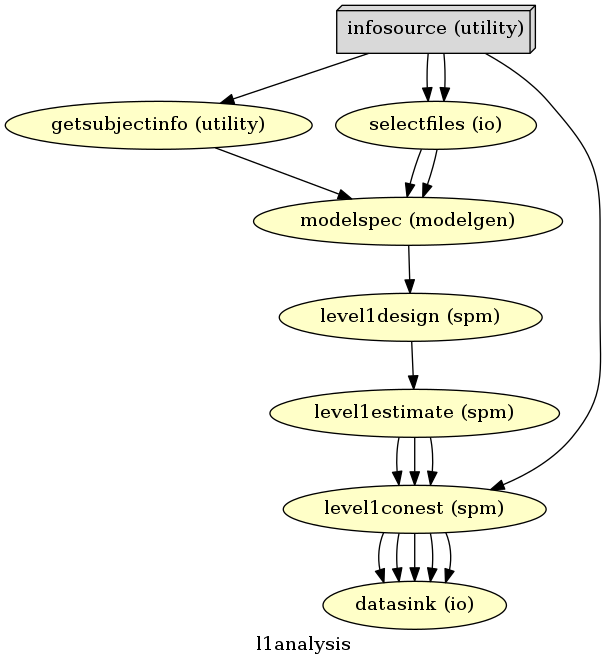

In [250]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [251]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

# !nipypecli crash /home/neuro/nipype_tutorial/crash-20171203-084943-neuro-getsubjectinfo.a0-ff371092-d758-40cb-a8ea-546235f16065.pklz

171203-13:08:47,282 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
171203-13:08:47,688 workflow INFO:
	 Running in parallel.
171203-13:08:47,727 workflow INFO:
	 Currently running 0 tasks, and 2 jobs ready. Free memory (GB): 5.14/5.14, Free processors: 4/4
171203-13:08:47,739 workflow INFO:
	 [Job finished] jobname: getsubjectinfo.a0 jobid: 0
171203-13:08:47,754 workflow INFO:
	 Executing node l1analysis.selectfiles in dir: /output/workingdir/l1analysis/_fwhm_id_4_subject_id_sub-1/selectfiles
171203-13:08:47,773 workflow INFO:
	 Running node "selectfiles" ("nipype.interfaces.io.SelectFiles").
171203-13:08:49,752 workflow INFO:
	 [Job finished] jobname: selectfiles.a0 jobid: 1
171203-13:08:49,759 workflow INFO:
	 Currently running 0 tasks, and 1 jobs ready. Free memory (GB): 5.14/5.14, Free processors: 4/4
171203-13:08:49,806 workflow INFO:
	 [Job finished] jobname: modelspec.a0 jobid: 2
171203-13:08:51,854 workflow INFO:
	 [Job finished] jobname: level

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save. You should have nine contrast images (``con_*.nii`` for T-contrasts and ``ess_*.nii`` for T-contrasts) and nine statistic images (``spmT_*.nii`` and ``spmF_*.nii``) for every subject and smoothing kernel.

In [119]:
!tree /output/datasink/1stLevel

/output/datasink/1stLevel
└── sub-1_fwhm4
    ├── con_0001.nii
    ├── con_0002.nii
    ├── ess_0003.nii
    ├── spmF_0003.nii
    ├── SPM.mat
    ├── spmT_0001.nii
    └── spmT_0002.nii

1 directory, 7 files


## Visualize results

Let's look at the contrasts of one subject that we've just computed using the anatomical coregistration.

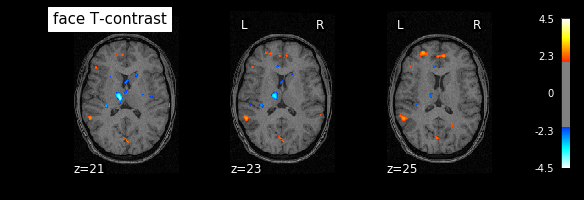

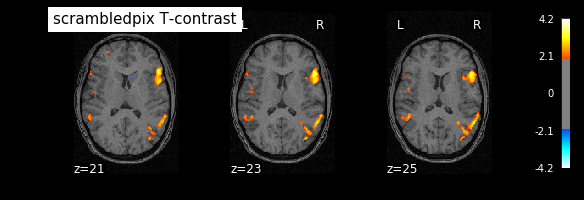

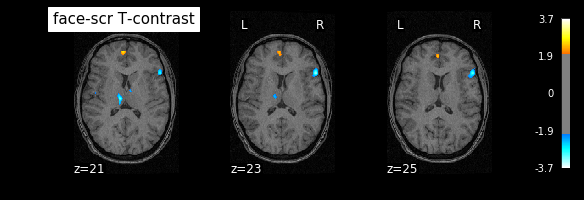

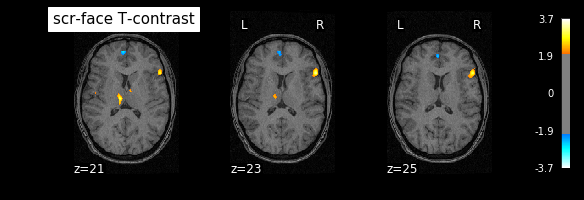

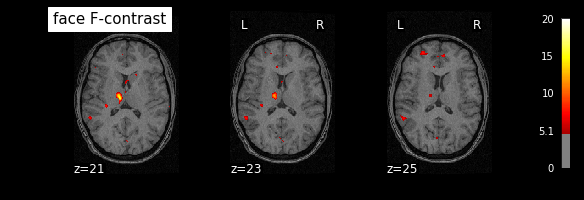

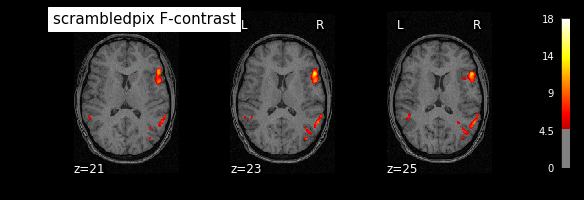

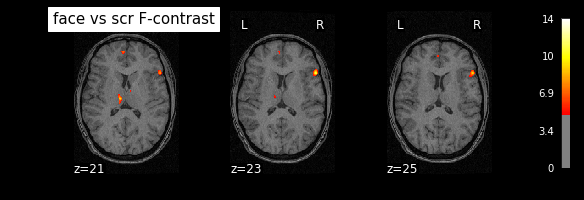

In [209]:
from nilearn.plotting import plot_stat_map
anatimg = data_dir+'/sub-1/anat/sub-1_T1w.nii.gz'
plot_stat_map(
    output_dri+'1stLevel/sub-1_fwhm4/spmT_0001.nii', title=contL1,
    bg_img=anatimg, threshold=2, display_mode='z', cut_coords=(21, 23, 25), dim=-1)
plot_stat_map(
    output_dri+'1stLevel/sub-1_fwhm4/spmT_0002.nii', title=contL2,
    bg_img=anatimg, threshold=2, display_mode='z', cut_coords=(21, 23, 25), dim=-1)
plot_stat_map(
    output_dri+'1stLevel/sub-1_fwhm4/spmT_0003.nii', title=contL3,
    bg_img=anatimg, threshold=2, display_mode='z', cut_coords=(21, 23, 25), dim=-1)
plot_stat_map(
    output_dri+'1stLevel/sub-1_fwhm4/spmT_0004.nii', title=contL4,
    bg_img=anatimg, threshold=2, display_mode='z', cut_coords=(21, 23, 25), dim=-1)


plot_stat_map(
    output_dri+'/1stLevel/sub-1_fwhm4/spmF_0005.nii', title=contL5,
    bg_img=anatimg, threshold=5, display_mode='z', cut_coords=(21, 23, 25), dim=-1)

plot_stat_map(
    output_dri+'/1stLevel/sub-1_fwhm4/spmF_0006.nii', title=contL6,
    bg_img=anatimg, threshold=5, display_mode='z', cut_coords=(21, 23, 25), dim=-1)

plot_stat_map(
    output_dri+'/1stLevel/sub-1_fwhm4/spmF_0007.nii', title=contL7,
    bg_img=anatimg, threshold=5, display_mode='z', cut_coords=(21, 23, 25), dim=-1)




# Resampling to MNI152 Template

In [252]:
from nilearn.image import resample_to_img
from nilearn.datasets import load_mni152_template
from nilearn.image import load_img


template = load_mni152_template()

tmap_file = output_dri+'/1stLevel/sub-1_fwhm4/spmT_0001.nii'
tmap1 = resample_to_img(tmap_file, template)

tmap_file = output_dri+'/1stLevel/sub-1_fwhm4/spmT_0002.nii'
tmap2 = resample_to_img(tmap_file, template)

tmap_file = output_dri+'/1stLevel/sub-1_fwhm4/spmT_0003.nii'
tmap3 = resample_to_img(tmap_file, template)

tmap_file = output_dri+'/1stLevel/sub-1_fwhm4/spmT_0004.nii'
tmap4 = resample_to_img(tmap_file, template)

tmap_file = output_dri+'/1stLevel/sub-1_fwhm4/spmF_0005.nii'
tmap5 = resample_to_img(tmap_file, template)

tmap_file = output_dri+'/1stLevel/sub-1_fwhm4/spmF_0006.nii'
tmap6 = resample_to_img(tmap_file, template)

tmap_file = output_dri+'/1stLevel/sub-1_fwhm4/spmF_0007.nii'
tmap7 = resample_to_img(tmap_file, template)

# Plots

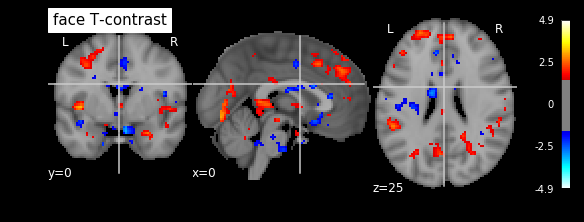

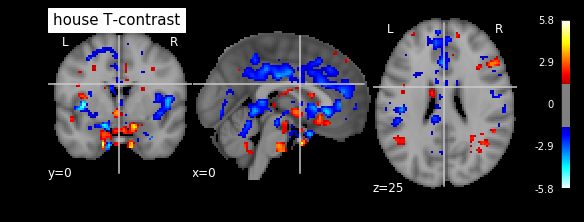

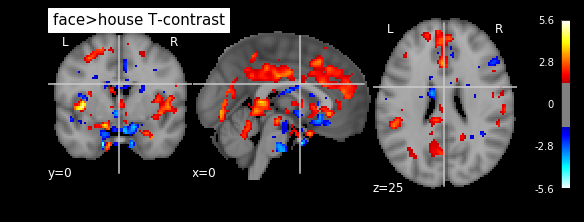

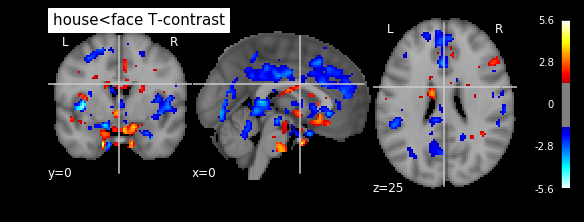

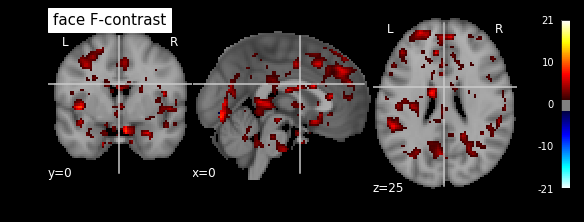

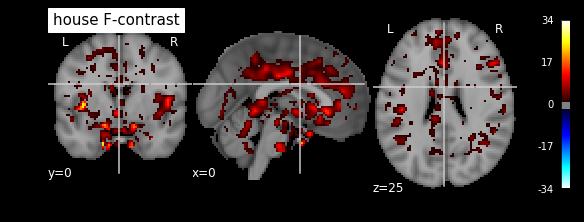

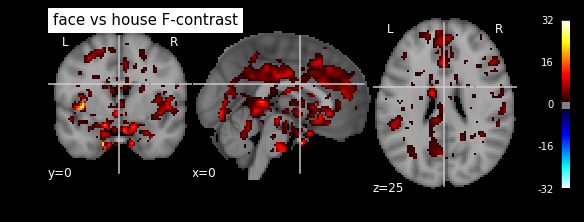

In [253]:
from nilearn import plotting

cut_coords = (0, 0, 25)
threshold = 1.5
plotting.plot_stat_map(tmap1,
                       bg_img=template,
                       cut_coords=cut_coords,
                       threshold=threshold,
                       title=contL1)
plotting.plot_stat_map(tmap2,
                       bg_img=template,
                       cut_coords=cut_coords,
                       threshold=threshold,
                       title=contL2)
plotting.plot_stat_map(tmap3,
                       bg_img=template,
                       cut_coords=cut_coords,
                       threshold=threshold,
                       title=contL3)
plotting.plot_stat_map(tmap4,
                       bg_img=template,
                       cut_coords=cut_coords,
                       threshold=threshold,
                       title=contL4)
plotting.plot_stat_map(tmap5,
                       bg_img=template,
                       cut_coords=cut_coords,
                       threshold=threshold,
                       title=contL5)
plotting.plot_stat_map(tmap6,
                       bg_img=template,
                       cut_coords=cut_coords,
                       threshold=threshold,
                       title=contL6)
plotting.plot_stat_map(tmap7,
                       bg_img=template,
                       cut_coords=cut_coords,
                       threshold=threshold,
                       title=contL7)
plotting.show()